# Fig. 3: Shape descriptors used to measure phosphene variability

In [1]:
import os
import os.path as osp
import numpy as np

import argus_shapes as shapes

%matplotlib inline
import matplotlib.pyplot as plt
# plt.style.use('seaborn-colorblind')

/home/mbeyeler/anaconda3/lib/python3.5/site-packages/skvideo/__init__.py:356: UserWarning: avconv/avprobe not found in path: 
  warnings.warn("avconv/avprobe not found in path: " + str(path), UserWarning)
2019-05-08 10:55:13,826 [pulse2percept] [INFO] Welcome to pulse2percept


In [2]:
def resample(Xy, subject, descriptor, within_subject=True, n_iter=1000, alpha=0.05):
    """Comparing observed shape descriptors to resampled data
    
    Observed values:  For each shape descriptor, generate a distribution of SEM values.
    Resampled values: Distribution of SEM values for randomly chosen drawings (either
                      within or across subjects)
                       
    Parameters
    ----------
    Xy : pd.DataFrame
        Data matrix. Should have a 'subject' field with value `subject`, and a field
        named `descriptor`.
    subject : str
        Subject name (e.g., 'S1')
    descriptor : str
        Shape descriptor name (e.g., 'area', 'orientation', 'elongation')
    within_subject : bool
        Whether to run the analysis within (True) or across subjects (False)
    n_iter : int
        Number of iterations
    alpha : float or list
        Significance level
    """
    electrodes = Xy[Xy.subject == subject].electrode.unique()
    n_trials = Xy[Xy.subject == subject].groupby('electrode').count().max().max()
    
    # Distribution of observed SEM values:
    sem_true = [Xy.loc[(Xy.subject == subject) & (Xy.electrode == electrode), descriptor].sem()
                for electrode in electrodes]
    
    # Bootstrapped distribution of SEM values:
    # Each distribution has `n_trials` * `len(electrodes)` drawings.
    # This is repeated `n_trials` times.
    rand_is_better = []
    mu_rand = []
    for _ in range(n_iter):
        if within_subject:
            # Restrict samples to same subject:
            sem_rand = [Xy.loc[(Xy.subject == subject), descriptor].sample(n=n_trials).sem()
                        for _ in range(len(electrodes))]
        else:
            # Sample from all subjects:
            sem_rand = [Xy[:, descriptor].sample(n=n_trials).sem() 
                        for _ in range(len(electrodes))]
        mu_rand.append(np.mean(sem_rand))
        
        # Random is better if mean abs angular error is larger than true array location:
        rand_is_better.append(np.mean(sem_true) > np.mean(sem_rand))

    # However, if this happens only a few times (smaller than `alpha` * `n_iter` times),
    # true array placement is overall significantly better:
    if isinstance(alpha, (list, np.ndarray)):
        is_signif = [np.sum(rand_is_better) < a * n_iter for a in alpha]
    else:
        is_signif = np.sum(rand_is_better) < alpha * n_iter

    return is_signif, np.mean(sem_true), mu_rand

In [3]:
# Assumes all data live in a directory ${DATA_ROOT}/argus_shapes, where DATA_ROOT is
# an environment variable. See README.md on GitHub.
# If no such environment variable exists, data will be automatically downloaded from
# OSF and stored in '../data/argus_shapes'
rootfolder = os.environ['DATA_ROOT'] if 'DATA_ROOT' in os.environ else osp.join('..', 'data')
datafolder = osp.join(rootfolder, 'argus_shapes')

In [4]:
# Load subject data:
subjectdata = shapes.load_subjects(osp.join(datafolder, 'subjects.csv'))
subjects = subjectdata.index.sort_values()

In [5]:
# Load drawings:
Xy = shapes.load_data(osp.join(datafolder, 'drawings_single.csv'))
Xy.drop(columns='image', inplace=True)

In [6]:
descriptors = ['area', 'orientation', 'eccentricity']
ylabels = ['area (pixels)', 'orientation (deg)', 'elongation']
colors = ['#0072B2', '#009E73', '#D55E00', '#CC79A7']
n_iter = 1000

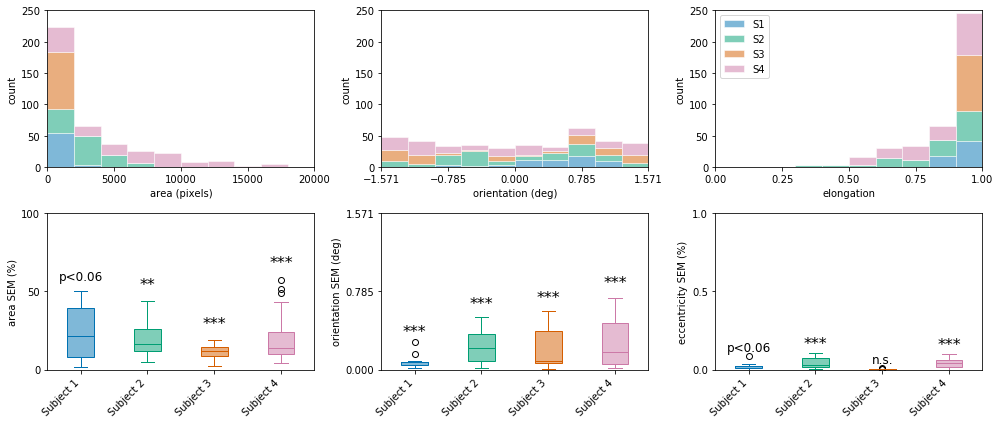

In [7]:
fig, axes = plt.subplots(nrows=2, ncols=len(descriptors), figsize=(14, 6))

xlimits = [[0, 20000], [-np.pi/2, np.pi/2], [0, 1]]
show_medians = False

for ax, desc, color, xlim, ylabel in zip(axes[0], descriptors, colors, xlimits, ylabels):
    vals = [Xy.loc[Xy.subject == subject, desc].values for subject in subjects]
    ax.hist(vals, color=colors, label=list(subjects), range=xlim,
            edgecolor='w', linewidth=1, alpha=0.5,
            orientation='vertical', stacked=True)
    if show_medians:
        a = ax.axis()
        if desc != 'orientation':
            for v, c in zip(vals, colors):
                ax.plot([np.median(v), np.median(v)], [a[2], a[3]], '--', 
                        color=c, linewidth=2)
    ax.set_xlim(*xlim)
    ax.set_ylim(0, 250)
    ax.set_xticks(np.linspace(*xlim, num=5))
    ax.set_ylabel('count')
    ax.set_xlabel(ylabel)
    if desc == descriptors[-1]:
        ax.legend(loc='upper left')
        
ylimits = [[0, 100], [0, np.pi/2], [0, 1]]        
for ax, desc, ylim in zip(axes[1], descriptors, ylimits):
    for s, (subject, color) in enumerate(zip(subjects, colors)):
        # Boxplots:
        vals = [data[desc].sem() / data[desc].mean() * 100
                if desc == 'area' else data[desc].sem()
                for _, data in Xy[Xy.subject == subject].groupby('electrode')]
        bp = ax.boxplot([vals], positions=[s], widths=0.4, patch_artist=True,
                        medianprops={'color': color}, capprops={'color': color},
                        flierprops={'color': color}, whiskerprops={'color': color})
        rgba = tuple([int(color.lstrip('#')[i:i+2], 16) / 255 for i in (0, 2 ,4)] + [0.5])
        [patch.set_facecolor(rgba) for patch in bp['boxes']]
        [patch.set_edgecolor(color) for patch in bp['boxes']]
        # Resample analysis:
        alphas = [0.06, 0.05, 0.01, 0.001]
        is_signif, _, _ = resample(Xy, subject, desc, within_subject=True, 
                                   alpha=alphas, n_iter=n_iter)
        if is_signif[3]:
            txt = '***'
            fs = 16
        elif is_signif[2]:
            txt = '**'
            fs = 16
        elif is_signif[1]:
            txt = '*'
            fs = 16
        elif is_signif[0]:
            txt = 'p<0.06'
            fs = 12
        else:
            txt = 'n.s.'
            fs = 12
        lims = ax.axis()
        ax.text(s, np.max(vals) + 0.1 * (lims[3] - lims[2]), txt, fontsize=fs,
                ha='center', va='bottom')
            
    ax.set_xlim(-0.5, 3.5)
    ax.set_xticks(np.arange(len(subjects)))
    ax.set_xticklabels([s.replace("S", "Subject ") for s in subjects], ha='right', rotation=45)
    ax.set_ylim(*ylim)
    ax.set_yticks(np.linspace(*ylim, num=3))
    ax.set_ylabel('%s SEM (%s)' % (desc, 'deg' if desc == 'orientation' else '%'))
    
fig.tight_layout()
fig.savefig('fig3-shape-descriptors.png')
fig.savefig('fig3-shape-descriptors.pdf', transparent=True)